In [2046]:
import pandas as pd
import os

from sklearn.preprocessing import OrdinalEncoder
from sklearn import metrics

from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight

 
DATA_FOLDER_PTH=os.path.join(os.getcwd(), os.pardir, 'data')
 
TRAIN_AUDIO_FOLDER_PTH=os.path.join(DATA_FOLDER_PTH, 'raw/MELD/train', 'train_splits')
TRAIN_TEXT_FILE_PTH=os.path.join(DATA_FOLDER_PTH, 'raw/MELD/train', 'train_sent_emo.csv')
 
DEV_AUDIO_FOLDER_PTH=os.path.join(DATA_FOLDER_PTH, 'raw/MELD/dev', 'dev_splits_complete')
DEV_TEXT_FILE_PTH=os.path.join(DATA_FOLDER_PTH, 'raw/MELD/dev', 'dev_sent_emo.csv')
 
TEST_AUDIO_FOLDER_PTH=os.path.join(DATA_FOLDER_PTH, 'raw/MELD/test', 'output_repeated_splits_test')
TEST_TEXT_FILE_PTH=os.path.join(DATA_FOLDER_PTH, 'raw/MELD/test', 'test_sent_emo.csv')

In [2047]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
            print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 2070 SUPER


In [2048]:
%run text_dataset.ipynb

In [2049]:
batchSize = 128
embedding_dim = 50


In [2050]:
train_dataset = TextDataset(dataset_type = 'train', label_target = 'Emotion', embedding_dim = embedding_dim)
val_dataset = TextDataset(dataset_type = 'validation', label_target = 'Emotion', embedding_dim = embedding_dim)

In [2051]:
train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          num_workers=0,
                          batch_size=batchSize,
                          pin_memory=True)

val_loader = DataLoader(val_dataset,
                          shuffle=True,
                          num_workers=0,
                          batch_size=batchSize,
                          pin_memory=True)

In [2052]:
train_dataset[4][0].size()

torch.Size([100, 50])

In [2053]:
#next(iter(train_loader))[0].size()

In [2054]:
%run text_model_simpleLSTM.ipynb
%run text_model_FNN.ipynb

## Train simpleLSTM for emotion

In [2064]:
# simpleLSTM or FNN
model = simpleLSTM(embedding_dim = embedding_dim, output_dim = 7)

model = model.to(device)
model

simpleLSTM(
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(50, 32, batch_first=True)
  (classifier): Linear(in_features=32, out_features=7, bias=True)
)

In [2065]:
labels = data['Emotion']
classes = ['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust', 'anger']

class_weights = compute_class_weight('balanced', classes = classes, y = np.array(labels))
class_weights = torch.tensor(class_weights, dtype=torch.float)

class_weights = class_weights.to(device)
print(class_weights)

tensor([0.3030, 1.1842, 5.3246, 2.0893, 0.8187, 5.2657, 1.2867],
       device='cuda:0')


In [2066]:
def trainLoop(model, train_loader, val_loader, shouldSave=False):
    
    model.train()
    
    EPOCHS = 20
    lr = 0.001
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adadelta(model.parameters())
    

    i = 0
    counterTrain = []
    lossHistoryTrain = []

    j = 0
    counterVal = []
    lossHistoryVal = []
    epochsSinceLastImprovement = 0
    bestLoss = None
    bestModel = model.state_dict()

    for epoch in tqdm(range(0, EPOCHS)):
        
        model.train()
        
        trainLoss = 0

        for data in train_loader:
            
            X, y = data
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            #print(X.shape)
            out = model(X)
            
            #print(out[0])
            #print(y)
            loss = criterion(out, y)
            loss.backward()
            
            trainLoss += loss.item()
            
            optimizer.step()

        trainLoss = trainLoss / len(train_loader)
            
        counterTrain.append(epoch)
        lossHistoryTrain.append(trainLoss)
        
        model.eval()
        with torch.no_grad():

            validationLoss = 0

            for data in val_loader:

                X, y = data
                X = X.to(device)
                y = y.to(device)
                
                out = model(X)

                loss = criterion(out, y)

                validationLoss += loss

            
            validationLoss = validationLoss / len(val_loader)
            
            counterVal.append(epoch)
            lossHistoryVal.append(validationLoss)


    return model, counterTrain, lossHistoryTrain, counterVal, lossHistoryVal

In [2067]:
model, counterTrain, lossHistoryTrain, counterVal, lossHistoryVal = trainLoop(model, train_loader, val_loader)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:41<00:00,  2.07s/it]


In [2068]:
def plotLoss(counter_train, loss_history_train, counter_test, loss_history_test, shouldSave=False, shouldDisplay=True):
    
    plt.plot(counter_train, loss_history_train, label="Train")

    plt.plot(counter_test, loss_history_test, label="Val")
    
    plt.legend(['Train', 'Val'])
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

#     fig, ax = plt.subplots(2, figsize=(12.83, 9.19))
#     #fig.suptitle(f'BestModelAtEpoch: {self.earlyStoppedAtEpoch} lr: {self.lr}, weightDecay: {self.weightDecay}, momentum: {self.momentum}, batchSize:{self.batchSize}, optim: {self.optim}, lastLayerActivation:{self.lastLayerActivation}')

#     ax[0].plot(counter_train, loss_history_train, label="Train")
#     ax[0].grid(True)

#     ax[1].plot(counter_test, loss_history_test, label="Test")
#     ax[1].grid(True)

#     if shouldSave:
#         today = datetime.now()
#         path = "./Figures/" + today.strftime('%d_%m_%Y_%H_%M')
#         fig.tight_layout()
#         fig.subplots_adjust(top=.95)
#         plt.savefig(path, dpi=300)

    if shouldDisplay:
        plt.show()

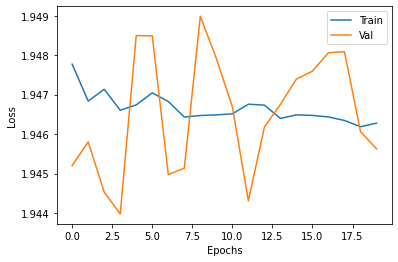

In [2069]:
plotLoss(counterTrain, lossHistoryTrain, counterVal, lossHistoryVal)

# Evaluation

In [2070]:
val_loader = DataLoader(val_dataset,
                          shuffle=False,
                          num_workers=0,
                          batch_size=len(val_dataset),
                          pin_memory=True)

In [2071]:
with torch.no_grad():
    
    model.eval()
    
    X, y = next(iter(val_loader))
    print(X.shape)
    print(y)
    X = X.to(device)
    
    out = model(X)
    print(out)
    predictions = F.softmax(out, dim=1).cpu()
    #print(predictions)
    
    predictions = torch.argmax(predictions, dim = 1).numpy().astype(dtype=np.float)
    y = y.numpy().astype(dtype=np.float)
    print(predictions)
    print(y)
    print(metrics.classification_report(y, predictions, target_names=classes))

torch.Size([1109, 100, 50])
tensor([3, 1, 0,  ..., 3, 3, 3])
tensor([[ 0.0312,  0.0465, -0.0317,  ..., -0.0249, -0.0550,  0.0072],
        [ 0.0312,  0.0465, -0.0317,  ..., -0.0249, -0.0550,  0.0072],
        [ 0.0312,  0.0465, -0.0317,  ..., -0.0249, -0.0550,  0.0072],
        ...,
        [ 0.0312,  0.0465, -0.0317,  ..., -0.0249, -0.0550,  0.0072],
        [ 0.0312,  0.0465, -0.0317,  ..., -0.0249, -0.0550,  0.0072],
        [ 0.0312,  0.0465, -0.0317,  ..., -0.0249, -0.0550,  0.0072]],
       device='cuda:0')
[1. 1. 1. ... 1. 1. 1.]
[3. 1. 0. ... 3. 3. 3.]
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00       470
    surprise       0.14      1.00      0.24       150
        fear       0.00      0.00      0.00        40
     sadness       0.00      0.00      0.00       111
         joy       0.00      0.00      0.00       163
     disgust       0.00      0.00      0.00        22
       anger       0.00      0.00      0.00       153


D:\ProgramData\Anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [2072]:
pd.DataFrame(metrics.confusion_matrix(y, predictions), index = classes, columns = classes)

,neutral,surprise,fear,sadness,joy,disgust,anger
neutral,0,470,0,0,0,0,0
surprise,0,150,0,0,0,0,0
fear,0,40,0,0,0,0,0
sadness,0,111,0,0,0,0,0
joy,0,163,0,0,0,0,0
disgust,0,22,0,0,0,0,0
anger,0,153,0,0,0,0,0
